In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.linear_model import LassoCV
import json


## 数据处理部分

In [40]:
data = pd.read_pickle("data/data_processed_all_unscaled.pkl")
X_orig = data.drop(columns=['Purpose of visit to CITY', 'Number of nights in CITY']).to_numpy()
y = data['Number of nights in CITY'].to_numpy()

In [41]:
ss = np.load('data/outliers_unscaled.npz')
outliers = ss['outliers'].astype(int)
rows_to_remove = outliers
X_orig = np.delete(X_orig, rows_to_remove, axis=0)
y = np.delete(y, rows_to_remove)
print(rows_to_remove.shape)

# ss = np.load('data/outliers_scaled.npz')
# outliers = ss['outliers'].astype(int)
# rows_to_remove = outliers
# X_orig = np.delete(X_orig, rows_to_remove, axis=0)
# y = np.delete(y, rows_to_remove)



(9,)


In [42]:
pca_50 = PCA(n_components= 50)  
X_pca_50 = pca_50.fit_transform(X_orig)

pca_100 = PCA(n_components= 100)  
X_pca_100 = pca_100.fit_transform(X_orig)

pca_200 = PCA(n_components= 200)  
X_pca_200 = pca_200.fit_transform(X_orig)

In [43]:
select_50 = SelectKBest(score_func=f_regression, k=50)
X_selected_50 = select_50.fit_transform(X_orig, y)

select_100 = SelectKBest(score_func=f_regression, k=100)
X_selected_100 = select_100.fit_transform(X_orig, y)

select_200 = SelectKBest(score_func=f_regression, k=200)
X_selected_200 = select_200.fit_transform(X_orig, y)

In [44]:
tscv = TimeSeriesSplit(n_splits=5)

In [45]:
print(X_orig.shape)
print(y.shape)

(72361, 386)
(72361,)


In [46]:
print(y)

[  5.   6. 327. ...   4.   1.   2.]


In [47]:
def visualization(y_pred, y_reg_test):
    # 可视化
    # 1. 实际值 vs. 预测值
    plt.figure(figsize=(8, 6))
    plt.scatter(y_reg_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Ideal Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. 残差图
    residuals = y_reg_test - y_pred
    abs_residuals = np.abs(residuals)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, abs_residuals, color='green', alpha=0.7)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')
    plt.grid(True)
    plt.show()

    # 3. 残差分布直方图
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=20, color='purple', alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True)
    plt.show()

## Search for Outliers

2it [00:00,  6.77it/s]

Linear Regression -Fold 1 - MSE: 38672453560150289005259259904.00, MAE: 32812771458150.53, R2: -245166193039184384063700992.00
157.73974821222336
2769
Linear Regression -Fold 2 - MSE: 31810369090346679734609379328.00, MAE: 4229775767583.33, R2: -291792165983158585834602496.00
109.01721430102644
10


3it [00:00,  5.25it/s]

Linear Regression -Fold 3 - MSE: 110110342686820600674235973632.00, MAE: 4499060028820.71, R2: -815127387350473166548893696.00
135.08360091387462
6


4it [00:00,  3.96it/s]

Linear Regression -Fold 4 - MSE: 50857843343530685134058553344.00, MAE: 122972648187874.97, R2: -305000904387204307262373888.00
166.7465329183605
5714


5it [00:01,  3.93it/s]

Linear Regression -Fold 5 - MSE: 10147387734702614258305204224.00, MAE: 1052391799741.50, R2: -310598440044266549869019136.00
32.67044011314547
2


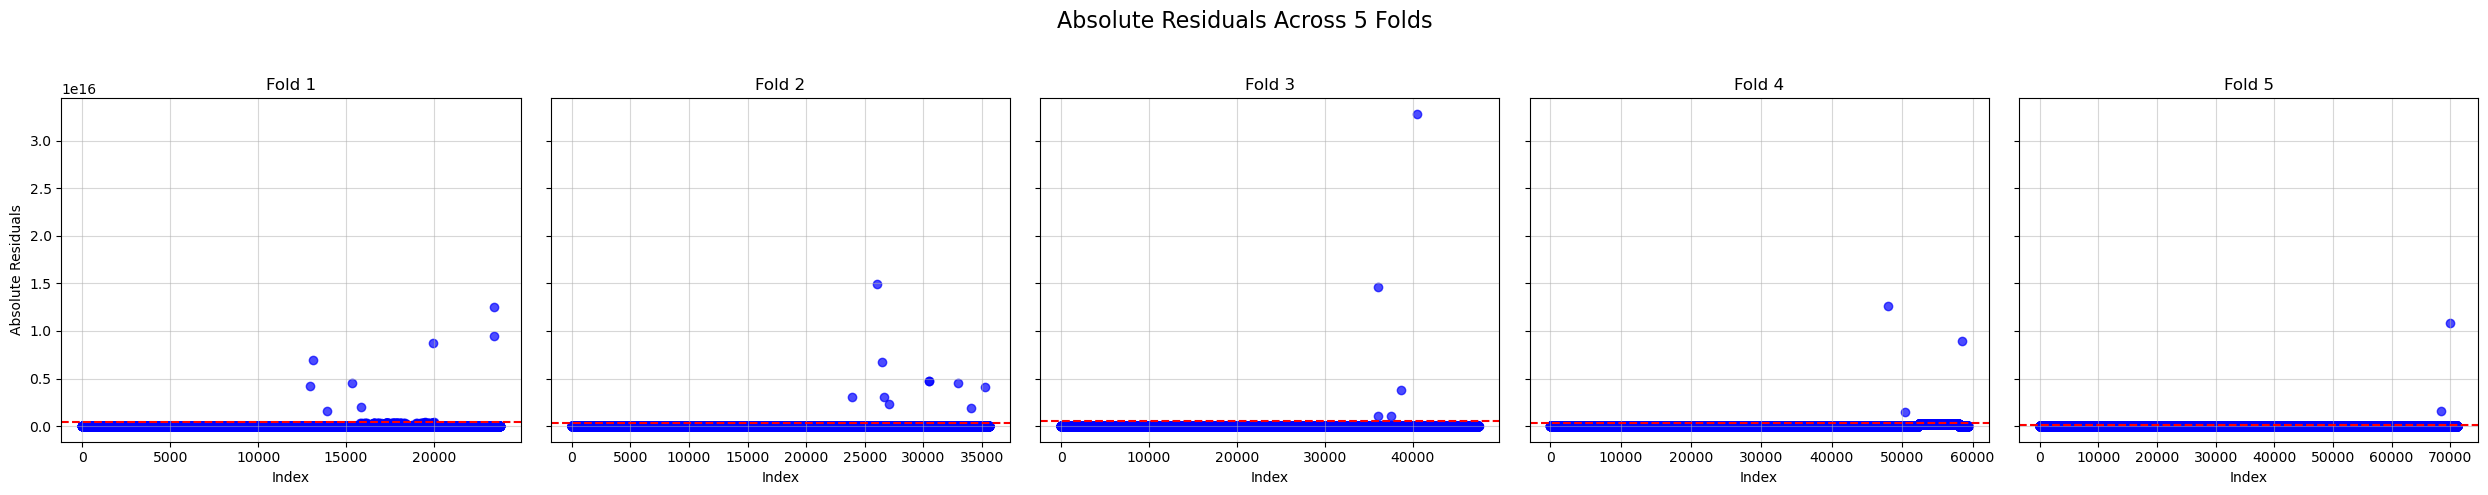

In [19]:
name = 'Linear Regression'

X = X_orig

X = StandardScaler().fit_transform(X_orig)

all_outliers = set()
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)  # 创建一个包含 5 个水平排列的小图的画布
for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y[train_idx], y[test_idx]
    model = LinearRegression(n_jobs=20)
    model.fit(X_train, y_reg_train)
    y_pred = model.predict(X_test)
    
    print(f'{name} -Fold {fold + 1} - MSE: {mean_squared_error(y_reg_test, y_pred):.2f}, '
          f'MAE: {mean_absolute_error(y_reg_test, y_pred):.2f}, '
          f'R2: {r2_score(y_reg_test, y_pred):.2f}')
    print(y_reg_test.var())
    
    # 计算残差
    yy = np.concatenate([y_reg_train, y_reg_test], axis=0)
    xx = np.concatenate([X_train, X_test], axis=0)
    yy_pred = model.predict(xx)
    residuals = yy - yy_pred
    abs_residuals = np.abs(residuals)
    threshold = 1e3
    outliers = abs_residuals > threshold
    all_outliers.update(np.where(outliers == 1)[0])  # 添加索引到集合
    print(outliers.sum())
    
    # 绘制第 fold 小图
    axes[fold].scatter(np.arange(xx.shape[0]), abs_residuals, color='blue', alpha=0.7)
    axes[fold].axhline(y=3 * np.std(residuals), color='red', linestyle='--')
    axes[fold].set_title(f'Fold {fold + 1}')
    axes[fold].set_xlabel('Index')
    if fold == 0:  # 只在第一个子图显示 y 轴标签
        axes[fold].set_ylabel('Absolute Residuals')
    axes[fold].grid(alpha=0.5)

plt.suptitle('Absolute Residuals Across 5 Folds', fontsize=16)  # 设置总标题
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以适应标题
plt.show()


In [20]:
all_outliers = list(all_outliers)
print(len(all_outliers))
# np.savez('data/outliers_scaled.npz', outliers=all_outliers)

8501


## Linear Regression

In [25]:
name = 'Linear Regression'

feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        model = LinearRegression(n_jobs=20)
        model.fit(X_train, y_reg_train)

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")

Linear Regression-Original - Fold 0  - MSE: 160.57, MAE: 4.20, R2: -0.02
Linear Regression-Original - Fold 1  - MSE: 106.02, MAE: 3.60, R2: 0.03
Linear Regression-Original - Fold 2  - MSE: 128.20, MAE: 3.53, R2: 0.05
Linear Regression-Original - Fold 3  - MSE: 162.65, MAE: 3.64, R2: 0.02
Linear Regression-Original - Fold 4  - MSE: 30.45, MAE: 1.41, R2: 0.07

Weighted Average Performance Across 5 Folds:
Linear Regression-Original - MSE: 104.00 - MAE: 2.91 - R2: 0.04
Average Performance Across 5 Folds:
Linear Regression-Original - MSE: 117.58 - MAE: 3.27 - R2: 0.03

Linear Regression-PCA_50 - Fold 0  - MSE: 159.74, MAE: 4.08, R2: -0.01
Linear Regression-PCA_50 - Fold 1  - MSE: 105.32, MAE: 3.55, R2: 0.03
Linear Regression-PCA_50 - Fold 2  - MSE: 127.89, MAE: 3.50, R2: 0.05
Linear Regression-PCA_50 - Fold 3  - MSE: 162.49, MAE: 3.66, R2: 0.03
Linear Regression-PCA_50 - Fold 4  - MSE: 30.22, MAE: 1.32, R2: 0.08

Weighted Average Performance Across 5 Folds:
Linear Regression-PCA_50 - MSE: 1

## Polynomial Regression

In [ ]:
name = 'Polynomial Regression'
degree = 2

feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    x = X[:, :11]
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(x)
    X_poly = np.hstack((X_poly, X[:, 11:]))

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_poly)):
        X_train, X_test = X_poly[train_idx], X_poly[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        model = LinearRegression(n_jobs=20)
        model.fit(X_train, y_reg_train)

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")


Weighted Average Performance Across 5 Folds:
Polynomial Regression-Original - MSE: 377002.86 - MAE: 13.01 - R2: -956.31
Average Performance Across 5 Folds:
Polynomial Regression-Original - MSE: 809492.29 - MAE: 21.71 - R2: -2187.39


Weighted Average Performance Across 5 Folds:
Polynomial Regression-PCA_50 - MSE: 535222.71 - MAE: 15.33 - R2: -1492.68
Average Performance Across 5 Folds:
Polynomial Regression-PCA_50 - MSE: 1522686.09 - MAE: 32.04 - R2: -4303.47


Weighted Average Performance Across 5 Folds:
Polynomial Regression-PCA_100 - MSE: 261398.19 - MAE: 15.07 - R2: -711.58
Average Performance Across 5 Folds:
Polynomial Regression-PCA_100 - MSE: 696624.08 - MAE: 29.88 - R2: -1950.44


Weighted Average Performance Across 5 Folds:
Polynomial Regression-PCA_200 - MSE: 447483.54 - MAE: 15.13 - R2: -1163.67
Average Performance Across 5 Folds:
Polynomial Regression-PCA_200 - MSE: 1039624.55 - MAE: 26.70 - R2: -2849.19


Weighted Average Performance Across 5 Folds:
Polynomial Regression-

## Ridge

In [27]:
ridge_params = {
    'alpha': [0.1, 1, 10, 100]
    }
name = 'Ridge'

feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        # Train the model with GridSearchCV
        model = Ridge(solver='auto')
        grid = GridSearchCV(model, ridge_params, cv=3, scoring='neg_mean_squared_error', n_jobs=16)
        grid.fit(X_train, y_reg_train)
        model = grid.best_estimator_

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")


Weighted Average Performance Across 5 Folds:
Ridge-Original - MSE: 103.72 - MAE: 2.89 - R2: 0.04
Average Performance Across 5 Folds:
Ridge-Original - MSE: 117.08 - MAE: 3.25 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Ridge-PCA_50 - MSE: 103.58 - MAE: 2.85 - R2: 0.05
Average Performance Across 5 Folds:
Ridge-PCA_50 - MSE: 116.86 - MAE: 3.21 - R2: 0.04


Weighted Average Performance Across 5 Folds:
Ridge-PCA_100 - MSE: 103.70 - MAE: 2.89 - R2: 0.05
Average Performance Across 5 Folds:
Ridge-PCA_100 - MSE: 117.06 - MAE: 3.25 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Ridge-PCA_200 - MSE: 103.72 - MAE: 2.89 - R2: 0.04
Average Performance Across 5 Folds:
Ridge-PCA_200 - MSE: 117.08 - MAE: 3.25 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Ridge-Select50Best - MSE: 104.37 - MAE: 2.93 - R2: 0.03
Average Performance Across 5 Folds:
Ridge-Select50Best - MSE: 117.10 - MAE: 3.27 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Ridge-Select100Best

## Lasso

In [28]:
name = "Lasso"

feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        model = LassoCV(cv=5, max_iter=10000, n_jobs=20, random_state=42)
        model.fit(X_train, y_reg_train)

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")


Weighted Average Performance Across 5 Folds:
Lasso-Original - MSE: 103.75 - MAE: 2.76 - R2: 0.05
Average Performance Across 5 Folds:
Lasso-Original - MSE: 116.99 - MAE: 3.10 - R2: 0.04


Weighted Average Performance Across 5 Folds:
Lasso-PCA_50 - MSE: 103.85 - MAE: 2.73 - R2: 0.04
Average Performance Across 5 Folds:
Lasso-PCA_50 - MSE: 117.05 - MAE: 3.08 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Lasso-PCA_100 - MSE: 103.85 - MAE: 2.73 - R2: 0.04
Average Performance Across 5 Folds:
Lasso-PCA_100 - MSE: 117.05 - MAE: 3.08 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Lasso-PCA_200 - MSE: 103.85 - MAE: 2.73 - R2: 0.04
Average Performance Across 5 Folds:
Lasso-PCA_200 - MSE: 117.05 - MAE: 3.08 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Lasso-Select50Best - MSE: 104.70 - MAE: 2.88 - R2: 0.03
Average Performance Across 5 Folds:
Lasso-Select50Best - MSE: 117.46 - MAE: 3.19 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Lasso-Select100Best

## Decision Tree

In [29]:
Decision_Tree_params = {
    'max_depth': [100, 200, 500]
    }
name = 'Decision Tree'

feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        # Train the model with GridSearchCV
        model = DecisionTreeRegressor()
        grid = GridSearchCV(model, Decision_Tree_params, cv=3, scoring='neg_mean_squared_error', n_jobs=20)
        grid.fit(X_train, y_reg_train)
        model = grid.best_estimator_

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")


Weighted Average Performance Across 5 Folds:
Decision Tree-Original - MSE: 270.52 - MAE: 4.33 - R2: -2.66
Average Performance Across 5 Folds:
Decision Tree-Original - MSE: 295.28 - MAE: 4.53 - R2: -2.19


Weighted Average Performance Across 5 Folds:
Decision Tree-PCA_50 - MSE: 281.12 - MAE: 4.63 - R2: -2.96
Average Performance Across 5 Folds:
Decision Tree-PCA_50 - MSE: 291.20 - MAE: 4.77 - R2: -2.27


Weighted Average Performance Across 5 Folds:
Decision Tree-PCA_100 - MSE: 338.52 - MAE: 5.04 - R2: -4.36
Average Performance Across 5 Folds:
Decision Tree-PCA_100 - MSE: 335.09 - MAE: 5.13 - R2: -3.18


Weighted Average Performance Across 5 Folds:
Decision Tree-PCA_200 - MSE: 346.78 - MAE: 5.29 - R2: -4.41
Average Performance Across 5 Folds:
Decision Tree-PCA_200 - MSE: 337.75 - MAE: 5.30 - R2: -3.18


Weighted Average Performance Across 5 Folds:
Decision Tree-Select50Best - MSE: 264.64 - MAE: 4.64 - R2: -2.37
Average Performance Across 5 Folds:
Decision Tree-Select50Best - MSE: 281.51 

## SVR 

In [ ]:
name = 'SVR'

feature_sets = {
    # 'Original': X_orig,
    # 'PCA_50': X_pca_50,
    # 'PCA_100': X_pca_100,
    # 'PCA_200': X_pca_200,
    # 'Select50Best': X_selected_50,
    # 'Select100Best': X_selected_100,
    # 'Select200Best': X_selected_200,
    # 'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    # 'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    # 'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    # 'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    # 'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        # Train the model with GridSearchCV
        model = SVR(verbose=1, C=0.1, kernel="rbf", tol=1e-2)
        model.fit(X_train, y_reg_train)

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Weighted Average Performance Across 5 Folds:
SVR-Scaled_PCA_50 - MSE: 415.97 - MAE: 4.16 - R2: 0.00
Average Performance Across 5 Folds:
SVR-Scaled_PCA_50 - MSE: 409.27 - MAE: 4.17 - R2: 0.00

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Weighted Average Performance Across 5 Folds:
SVR-Scaled_Select50Best - MSE: 408.84 - MAE: 4.10 - R2: 0.02
Average Performance Across 5 Folds:
SVR-Scaled_Select50Best - MSE: 402.60 - MAE: 4.11 - R2: 0.02

Results and model parameters have been saved to 'linear_regression_results.json'


# 集成算法

## Random Forest

In [21]:
rf_params = {
    'n_estimators': [50, 100], 
    'max_depth': [50, 100, 200]
    }
name = 'Random Forest'

feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    # 'PCA_100': X_pca_100,
    # 'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    # 'Select100Best': X_selected_100,
    # 'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    # 'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    # 'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    # 'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    # 'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        # Train the model with GridSearchCV
        model = RandomForestRegressor(n_estimators=50, n_jobs=10)
        grid = GridSearchCV(model, rf_params, cv=2, n_jobs=10)
        grid.fit(X_train, y_reg_train)
        model = grid.best_estimator_

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")


Weighted Average Performance Across 5 Folds:
Random Forest-Original - MSE: 119.64 - MAE: 3.44 - R2: -0.35
Average Performance Across 5 Folds:
Random Forest-Original - MSE: 127.85 - MAE: 3.57 - R2: -0.22


Weighted Average Performance Across 5 Folds:
Random Forest-PCA_50 - MSE: 126.91 - MAE: 3.72 - R2: -0.49
Average Performance Across 5 Folds:
Random Forest-PCA_50 - MSE: 135.10 - MAE: 3.83 - R2: -0.32


Weighted Average Performance Across 5 Folds:
Random Forest-Select50Best - MSE: 135.20 - MAE: 3.72 - R2: -0.73
Average Performance Across 5 Folds:
Random Forest-Select50Best - MSE: 137.15 - MAE: 3.75 - R2: -0.45


Weighted Average Performance Across 5 Folds:
Random Forest-Scaled_Original - MSE: 119.81 - MAE: 3.42 - R2: -0.37
Average Performance Across 5 Folds:
Random Forest-Scaled_Original - MSE: 127.66 - MAE: 3.55 - R2: -0.23


Weighted Average Performance Across 5 Folds:
Random Forest-Scaled_PCA_50 - MSE: 128.39 - MAE: 3.75 - R2: -0.52
Average Performance Across 5 Folds:
Random Forest-

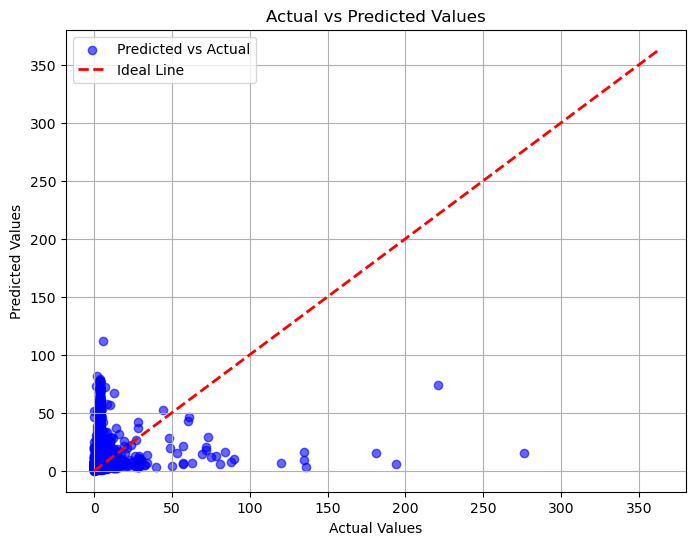

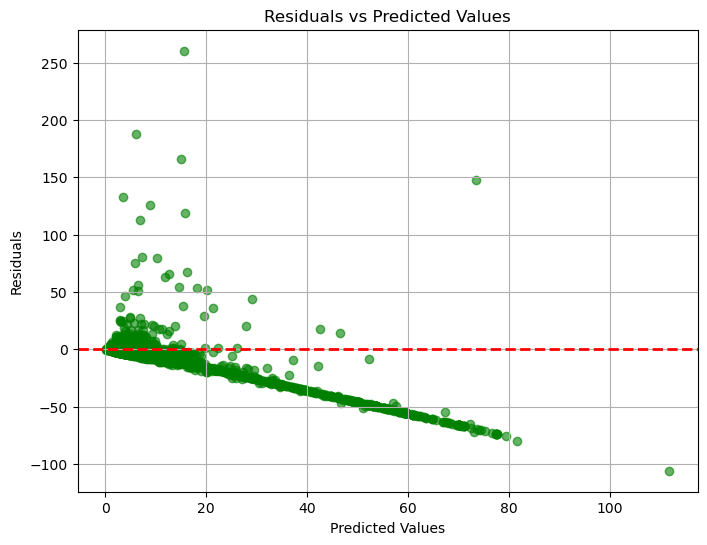

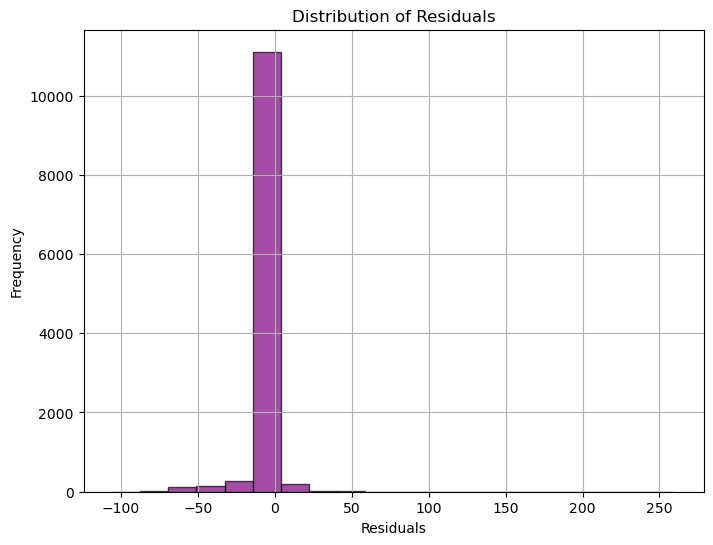

In [22]:
visualization(y_pred, y_reg_test)

## Bagging Method

In [23]:
name = 'Bagging'

feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=200), n_estimators=10, random_state=42, n_jobs=16)
        model.fit(X_train, y_reg_train)

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")


Weighted Average Performance Across 5 Folds:
Bagging-Original - MSE: 130.70 - MAE: 3.53 - R2: -0.53
Average Performance Across 5 Folds:
Bagging-Original - MSE: 140.33 - MAE: 3.69 - R2: -0.36


Weighted Average Performance Across 5 Folds:
Bagging-PCA_50 - MSE: 146.84 - MAE: 3.99 - R2: -0.80
Average Performance Across 5 Folds:
Bagging-PCA_50 - MSE: 153.65 - MAE: 4.08 - R2: -0.56


Weighted Average Performance Across 5 Folds:
Bagging-PCA_100 - MSE: 154.46 - MAE: 4.05 - R2: -0.97
Average Performance Across 5 Folds:
Bagging-PCA_100 - MSE: 161.71 - MAE: 4.15 - R2: -0.69


Weighted Average Performance Across 5 Folds:
Bagging-PCA_200 - MSE: 154.66 - MAE: 4.12 - R2: -0.99
Average Performance Across 5 Folds:
Bagging-PCA_200 - MSE: 162.92 - MAE: 4.22 - R2: -0.71


Weighted Average Performance Across 5 Folds:
Bagging-Select50Best - MSE: 152.84 - MAE: 4.08 - R2: -1.00
Average Performance Across 5 Folds:
Bagging-Select50Best - MSE: 155.91 - MAE: 4.06 - R2: -0.67


Weighted Average Performance Acros

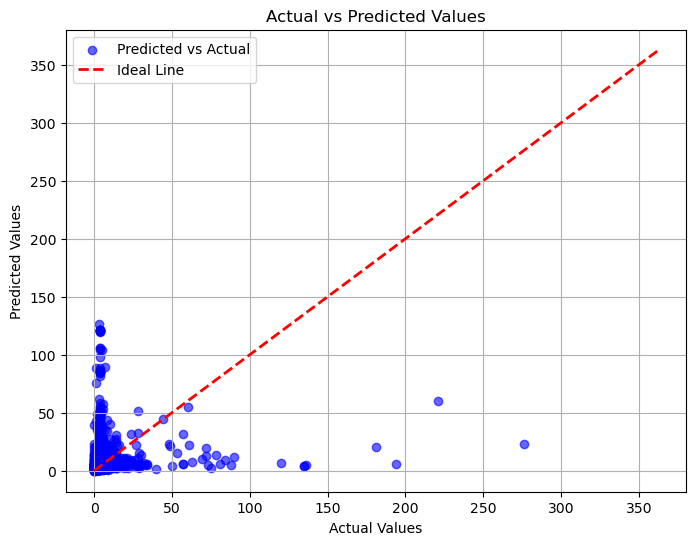

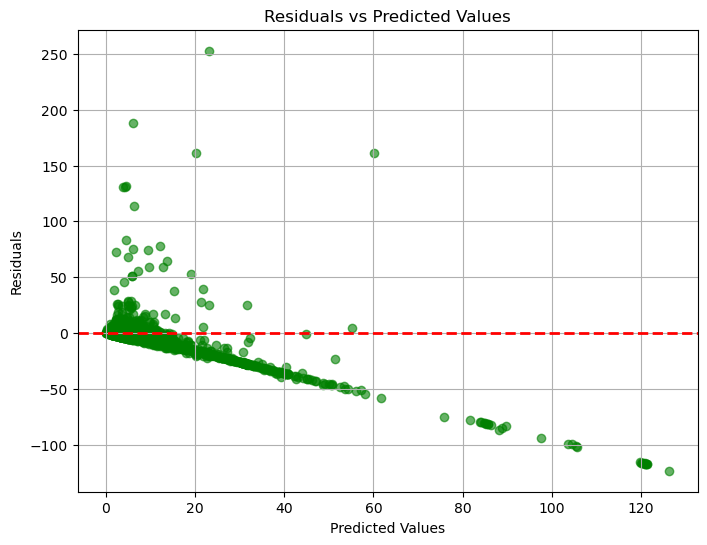

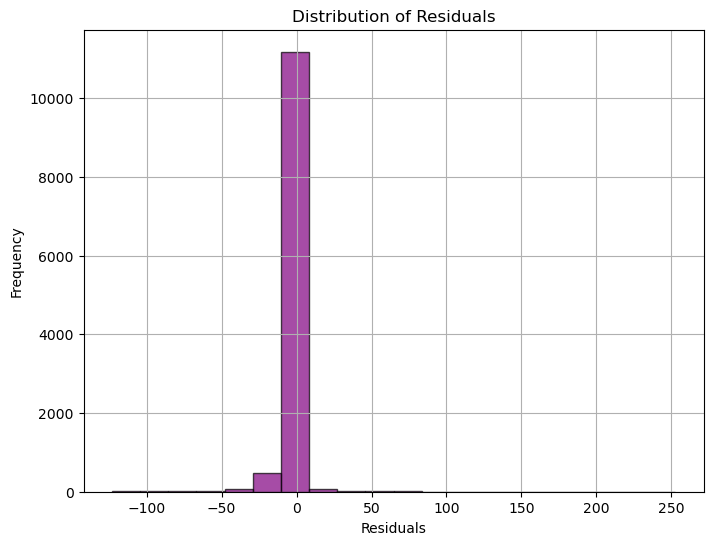

In [24]:
visualization(y_pred, y_reg_test)

## Stack

In [27]:
name = 'Stack'

feature_sets = {
    'Original': X_orig,
    'PCA_50': X_pca_50,
    'PCA_100': X_pca_100,
    'PCA_200': X_pca_200,
    'Select50Best': X_selected_50,
    'Select100Best': X_selected_100,
    'Select200Best': X_selected_200,
    'Scaled_Original': StandardScaler().fit_transform(X_orig),
    'Scaled_PCA_50': StandardScaler().fit_transform(X_pca_50),
    'Scaled_PCA_100': StandardScaler().fit_transform(X_pca_100),
    'Scaled_PCA_200': StandardScaler().fit_transform(X_pca_200),
    'Scaled_Select50Best': StandardScaler().fit_transform(X_selected_50),
    'Scaled_Select100Best': StandardScaler().fit_transform(X_selected_100),
    'Scaled_Select200Best': StandardScaler().fit_transform(X_selected_200)
}

# Dictionary to store results for all feature sets
results = {}

for feature_name, X in feature_sets.items():
    # Lists to store metrics and weights (test set sizes)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    weights = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_reg_train, y_reg_test = y[train_idx], y[test_idx]
        
        base_models = [
                ('lr', LinearRegression()),
                ('dt', DecisionTreeRegressor(max_depth=200))
                ]
        final_model = LinearRegression()
        model = StackingRegressor(estimators=base_models, final_estimator=final_model, n_jobs=16)
        model.fit(X_train, y_reg_train)

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_reg_test, y_pred)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        # Store metrics and weight (number of samples in test set)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        weights.append(len(train_idx))
        
        # Print per-fold results
        # print(f'{name}-{feature_name} - Fold {fold}  - MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')
    
    # Compute weighted averages
    weighted_mse = np.average(mse_scores, weights=weights)
    weighted_mae = np.average(mae_scores, weights=weights)
    weighted_r2 = np.average(r2_scores, weights=weights)
    
    # Compute simple averages
    avg_mse = np.average(mse_scores)
    avg_mae = np.average(mae_scores)
    avg_r2 = np.average(r2_scores)
    
    # Store results for this feature set
    results[feature_name] = {
        'fold_metrics': [
            {'fold': f, 'mse': mse, 'mae': mae, 'r2': r2}
            for f, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores)
        ],
        'weighted_averages': {
            'mse': float(weighted_mse),
            'mae': float(weighted_mae),
            'r2': float(weighted_r2)
        },
        'simple_averages': {
            'mse': float(avg_mse),
            'mae': float(avg_mae),
            'r2': float(avg_r2)
        }
    }
    
    # Print weighted average results
    print(f'\nWeighted Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {weighted_mse:.2f} - MAE: {weighted_mae:.2f} - R2: {weighted_r2:.2f}')
    
    # Print simple average results
    print(f'Average Performance Across 5 Folds:')
    print(f'{name}-{feature_name} - MSE: {avg_mse:.2f} - MAE: {avg_mae:.2f} - R2: {avg_r2:.2f}\n')

# Save results to JSON file
with open(f'results/reg_aug/{name}_results.json', 'w') as f:
    json.dump({
        'model_name': name,
        'feature_sets': results
    }, f, indent=4)

print("Results and model parameters have been saved to 'linear_regression_results.json'")


Weighted Average Performance Across 5 Folds:
Stack-Original - MSE: 104.00 - MAE: 2.89 - R2: 0.03
Average Performance Across 5 Folds:
Stack-Original - MSE: 116.68 - MAE: 3.21 - R2: 0.03


Weighted Average Performance Across 5 Folds:
Stack-PCA_50 - MSE: 104.57 - MAE: 3.05 - R2: 0.01
Average Performance Across 5 Folds:
Stack-PCA_50 - MSE: 116.79 - MAE: 3.29 - R2: 0.02


Weighted Average Performance Across 5 Folds:
Stack-PCA_100 - MSE: 342.19 - MAE: 4.96 - R2: -1.50
Average Performance Across 5 Folds:
Stack-PCA_100 - MSE: 828.93 - MAE: 8.89 - R2: -4.50


Weighted Average Performance Across 5 Folds:
Stack-PCA_200 - MSE: 108.36 - MAE: 3.14 - R2: -0.03
Average Performance Across 5 Folds:
Stack-PCA_200 - MSE: 120.46 - MAE: 3.37 - R2: -0.01


Weighted Average Performance Across 5 Folds:
Stack-Select50Best - MSE: 104.01 - MAE: 2.91 - R2: 0.04
Average Performance Across 5 Folds:
Stack-Select50Best - MSE: 115.91 - MAE: 3.22 - R2: 0.04


Weighted Average Performance Across 5 Folds:
Stack-Select100

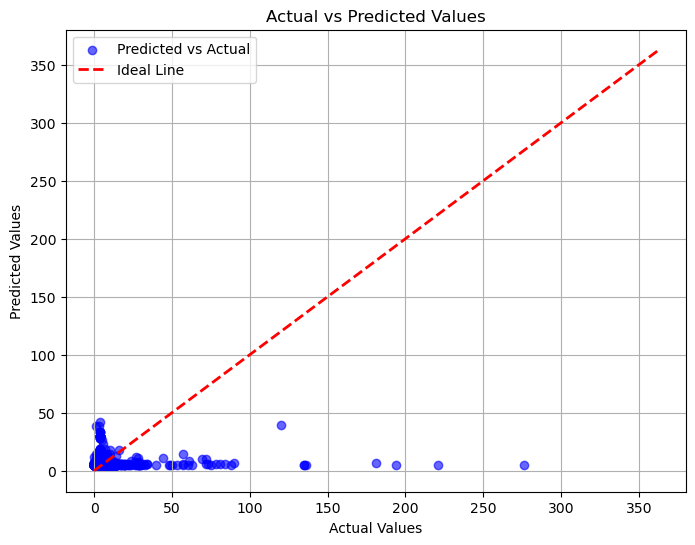

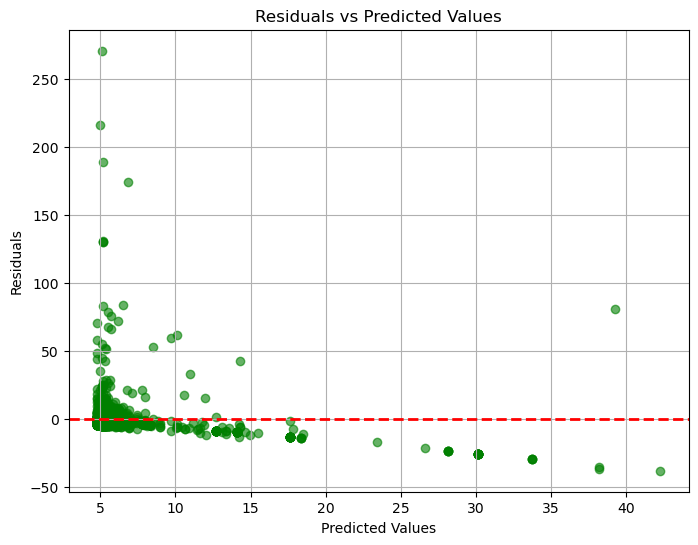

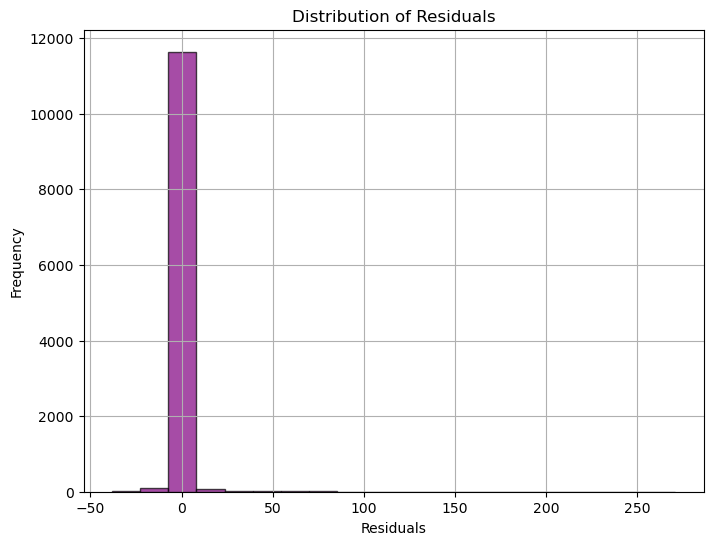

In [28]:
visualization(y_pred, y_reg_test)